In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import pyLCSIM
import carmcmc as cm
import glob, os,sys,timeit
import scipy.stats as sst
from scipy import interpolate
from matplotlib import rcParams
from matplotlib import pyplot as plt
from scipy.integrate import simps
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous
from astropy.convolution import convolve, Box1DKernel
from sklearn.neighbors import KernelDensity
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('my')

#def blockPrint():
#    sys.stdout = open(os.devnull, 'w')

# Restore
#def enablePrint():
#    sys.stdout = sys.__stdout__

### 1. Produce the simulated continuum light curve with PSD slope = -2, baseline = 200 days, mean flux = 30 (arbaritary unit), variability = 0.5 (std(flux) ~ 0.5) and Gaussian nosie with mean = 0.2 and std = 0.1

#### pyLCSIM is a flexable funciton that is enable to produce single or broken power-law PSDs and coresponding light curves.

Total number of photons: 185.776467871
flux std: 0.5253627056095695


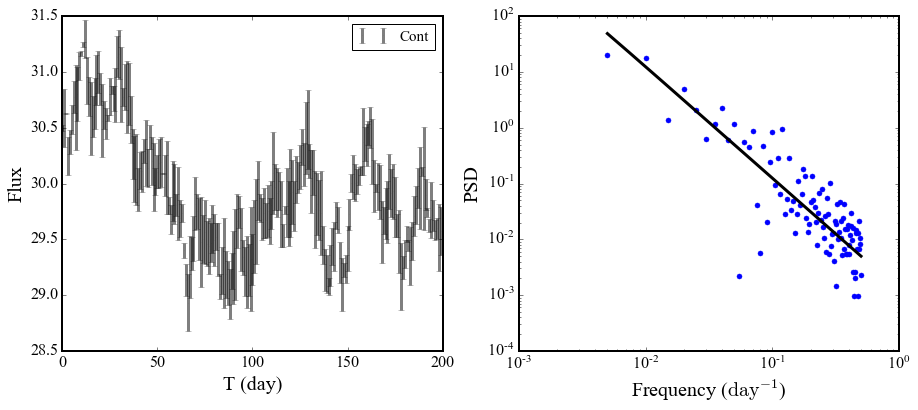

In [15]:
rate_src = 1.0
#rate_bkg = 3000.0
t_exp = 200.0
dt = 1.
frms=0.5

plt.figure(figsize=(15,6))
plt.subplot(121)
nbins = long(t_exp/dt)

dampT=200.0 #days
fbreak=1./(2*np.pi*dampT)
fb=np.log10(fbreak)



# Instantiate a simulation object
sim = pyLCSIM.Simulation()
# See the documentation for details.
sim.addModel('smoothbknpo', [1,0, 2, fbreak])  # Normalization, slope1,slope2, break f

# Run the simulation
sim.run(dt, nbins, rate_src, rms=frms)
#

time, rate = sim.getLightCurve()
mean=30
flux=(rate/rate_src-1.)+mean
f, psd = sim.getPowerSpectrum()
freq_m, model_tot, model_comp = sim.getPSDModel(dt, nbins, freq=100000)
model_tot = model_tot / simps(model_tot, freq_m) * simps(psd, f)

err=np.random.normal(0.2, 0.1, len(time)) # assume error with mu = 0 and sigma = 0.1


plt.errorbar(time,flux,yerr=err,color='k', fmt='.',ms=0.1,alpha=0.5,label='Cont')
plt.ylabel('Flux')
plt.xlabel('T (day)')
print 'flux std:', flux.std()
plt.legend(fontsize=15)
plt.subplot(122)

plt.plot(f,psd,'b.',markersize=10,rasterized=False)
plt.loglog(freq_m, model_tot,color='k')
plt.xlabel(r'Frequency ($\rm day^{-1}$)')
plt.ylabel("PSD")


### 2. Use the continuum light curve to produce line light curve assuming a transfer function (top hat function with width = 4 days) and lag = 17 days. Baseline ranges from 50 to 150 days to reject edges without data.

/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


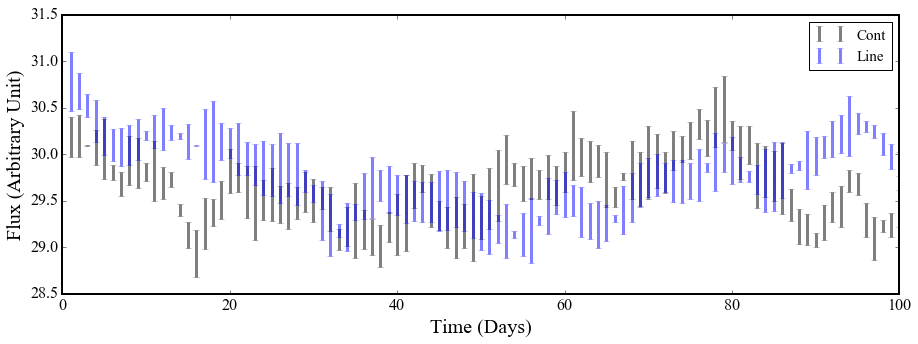

In [16]:
plt.figure(figsize=(15,5))
box_kernel = Box1DKernel(4)
lag=17.0  #days
flux_line = convolve(flux, box_kernel)
err_line= np.random.normal(0.2, 0.1, len(flux))

time_line=np.array(pd.DataFrame(time).shift(-1*int(lag))).flatten()


ind=np.where( (time>50) & (time<=150),True,False)
indl=np.where( (time_line>50) & (time_line<=150),True,False)

plt.errorbar(time[ind]-50,flux[ind],yerr=err[ind],color='k', fmt='.',ms=0.1,alpha=0.5, label='Cont')
plt.errorbar(time_line[indl]-50,flux_line[indl],yerr=err_line[indl],color='b',fmt='.',ms=0.1,alpha=0.5,label='Line')
plt.legend(loc='best',fontsize=15)
plt.xlabel('Time (Days)')
plt.ylabel('Flux (Arbitrary Unit)')



### 3. We randomly selected 70 points in continuum and emission line light curves as our real input data. 

/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 99 + 1) instead
  
/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 99 + 1) instead
  


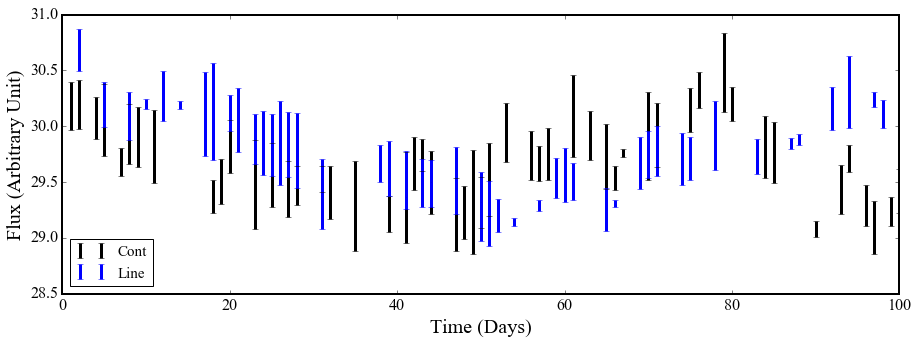

In [17]:
plt.figure(figsize=(15,5))
rand=np.unique(np.sort(np.random.random_integers(0,99,70)))
t_cont=time[ind][rand]-50
f_cont=flux[ind][rand]
e_cont=err[ind][rand]


rand=np.unique(np.sort(np.random.random_integers(0,99,70)))
t_line=time_line[indl][rand]-50
f_line=flux_line[indl][rand]
e_line=err_line[indl][rand]


plt.errorbar(t_cont,f_cont,yerr=e_cont,color='k', fmt='.',ms=0.1, label='Cont')
plt.errorbar(t_line,f_line,yerr=e_line,color='b', fmt='.',ms=0.1, label='Line')
plt.legend(loc='best',fontsize=15)

plt.xlabel('Time (Days)')
plt.ylabel('Flux (Arbitrary Unit)')

### 4. Write the basic ICCF, and test it with the data above.

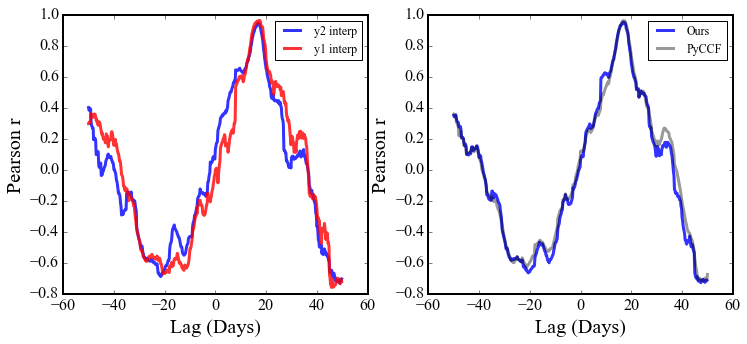

In [40]:

t1=t_cont
y1=f_cont
e1=e_cont
t2=t_line
y2=f_line
e2=e_line
tau_min=-50
tau_max=50
step=0.2

def iccf(t1,y1,t2,y2,tau_min,tau_max,step=0.2,imode=0):
    lag_12=[]
    r_12=[]
    npt_12=[]
    lag_21=[]
    r_21=[]
    npt_21=[]
    tau=tau_min
    while tau < tau_max:
        lag_12.append(tau)
        t2_new=t2+tau
        ind_t2=np.where( (t2_new >= np.min(t1)) & (t2_new <= np.max(t1)),True,False)
        ind_t1=np.where( (t1<=t2_new.max()) & (t1>=t2_new.min()),True,False)
        npt_12.append(min(np.sum(ind_t2),np.sum(ind_t1)))
        if npt_12 > 0:
            y2_new=np.interp(t1[ind_t1],t2_new[ind_t2],y2[ind_t2])
            r,p=sst.spearmanr(y1[ind_t1],y2_new)
            r_12.append(r)
            tau=tau+step
        else:
            raise Exception("No overlaping data in two light curves!")

    lag_12=np.array(lag_12)   
    r_12=np.array(r_12)
    r_12=r_12[::-1] 
    npt_12=np.array(npt_12)
    npt_12=npt_12[::-1]
    


    tau=tau_min
    while tau < tau_max:
        lag_21.append(tau)
        t1_new=t1+tau
        ind_t1=np.where( (t1_new >= np.min(t2)) & (t1_new <= np.max(t2)),True,False)
        ind_t2=np.where( (t2<=t1_new.max()) & (t2>=t1_new.min()),True,False)
        npt_21.append(min(np.sum(ind_t2),np.sum(ind_t1)))
        if npt_21 >0:
            y1_new=np.interp(t2[ind_t2],t1_new[ind_t1],y1[ind_t1])
            r,p=sst.spearmanr(y2[ind_t2],y1_new)
            r_21.append(r)
            tau=tau+step
        else:
            raise Exception("No overlaping data in two light curves!") 
    lag_21=np.array(lag_21)
    r_21=np.array(r_21)
    npt_21=np.array(npt_21)
    
    if imode==0:
        lag=(lag_12+lag_21)*0.5
        r=(r_12+r_21)*0.5
        npt=(npt_12+npt_21)*0.5
    elif imode==1:
        lag=lag_12
        r=r_12
        npt=npt_12
    elif imode==2:
        lag=lag_21
        r=r_21
        npt=npt_21    
    else:
        raise Exception("Please select imode = 0, 1 or 2!") 
    return lag, r, npt

#code from PyCCF Mouyuan Sun 2018
def xcor(t1, y1, t2, y2, tlagmin, tlagmax, tunit, imode=0):
    if np.sum(np.diff(t1)<0.0)>0 or np.sum(np.diff(t2)<0.0)>0:
        raise Exception("The time of light curve 1 or light curve 2 is NOT INCREASING!!! Please check your data!!!")
    n1 = len(y1)
    n2 = len(y2)
    if n1<2 or n2<2:
        raise Exception("The light curve should contain at least 2 data points!!!")
    safe = tunit*0.1
    taulist12 = []
    taulist21 = []
    npts12 = []
    npts21 = []
    ccf12 = []  # interpolate 2
    ccf21 = []  # interpolate 1
    tau_max = tlagmax+safe
    # first interpolate 2
    if imode != 1:
        tau = tlagmin + 0.0 # if imode=1, skip the interpolate 2 step
    else:
        tau = tau_max + 0.0
    while tau < tau_max:
        t2new = t1 + tau
        selin = np.where((t2new>=np.min(t2))&(t2new<=np.max(t2)), True, False)
        knot = np.sum(selin)  # number of datapoints used
        if knot>0:
            y2new = np.interp(t2new[selin], t2, y2)
            
            y1sum = np.sum(y1[selin])
            y1sqsum = np.sum(y1[selin]*y1[selin])
            y2sum = np.sum(y2new)
            y2sqsum = np.sum(y2new*y2new)
            y1y2sum = np.sum(y1[selin]*y2new)
            
            fn = float(knot)
            rd1_sq = fn*y2sqsum - y2sum*y2sum
            rd2_sq = fn*y1sqsum - y1sum*y1sum
            if rd1_sq>0.0:
                rd1 = np.sqrt(rd1_sq)
            else:
                rd1 = 0.0
            if rd2_sq>0.0:
                rd2 = np.sqrt(rd2_sq)
            else:
                rd2 = 0.0
            
            if rd1*rd2==0.0:
                r = 0.0
            else:
                r = (fn*y1y2sum - y2sum*y1sum)/(rd1*rd2)
            ccf12.append(r)
            taulist12.append(tau)
            npts12.append(knot)
        tau += tunit
    # now interpolate 1
    if imode != 2:
        tau = tlagmin + 0.0
    else:
        tau = tau_max + 0.0
    while tau < tau_max:
        t1new = t2 - tau
        selin = np.where((t1new>=np.min(t1))&(t1new<=np.max(t1)), True, False)
        knot = np.sum(selin)  # number of datapoints used
        if knot>0:
            y1new = np.interp(t1new[selin], t1, y1)
            
            y2sum = np.sum(y2[selin])
            y2sqsum = np.sum(y2[selin]*y2[selin])
            y1sum = np.sum(y1new)
            y1sqsum = np.sum(y1new*y1new)
            y1y2sum = np.sum(y1new*y2[selin])
            
            fn = float(knot)
            rd1_sq = fn*y2sqsum - y2sum*y2sum
            rd2_sq = fn*y1sqsum - y1sum*y1sum
            if rd1_sq>0.0:
                rd1 = np.sqrt(rd1_sq)
            else:
                rd1 = 0.0
            if rd2_sq>0.0:
                rd2 = np.sqrt(rd2_sq)
            else:
                rd2 = 0.0
            
            if rd1*rd2==0.0:
                r = 0.0
            else:
                r = (fn*y1y2sum - y2sum*y1sum)/(rd1*rd2)
            ccf21.append(r)
            taulist21.append(tau)
            npts21.append(knot)
        tau += tunit
    
    # return results according to imode
    taulist12 = np.asarray(taulist12)
    npts12 = np.asarray(npts12)
    taulist21 = np.asarray(taulist21)
    npts21 = np.asarray(npts21)
    ccf12 = np.asarray(ccf12)
    ccf21 = np.asarray(ccf21)
    if imode==0:
        # make sure taulist12 and taulist21 have the same size!!!
        if np.array_equal(taulist12, taulist21):
            ccf = (ccf12 + ccf21)*0.5
            taulist = taulist12 + 0.0
            npts = npts12 + 0.0
        else:
            taulist = np.intersect1d(taulist12, taulist21)
            sel_cb12 = np.in1d(taulist12, taulist)
            sel_cb21 = np.in1d(taulist21, taulist)
            ccf = (ccf12[sel_cb12] + ccf21[sel_cb21])*0.5
            npts = (npts12[sel_cb12] + npts21[sel_cb21])*0.5
    elif imode==1:
        ccf = ccf21 + 0.0
        taulist = taulist21 + 0.0
        npts = npts21 + 0.0
    else:
        ccf = ccf12 + 0.0
        taulist = taulist12 + 0.0
        npts = npts12 + 0.0
    
    return ccf, taulist, npts


plt.figure(figsize=(12,5))
plt.subplot(121)

lag,r,npt=iccf(t1,y1,t2,y2,-50.,50.,0.2,imode=1)
plt.plot(lag,r,'b',label='y2 interp',alpha=0.8)

lag,r,npt=iccf(t1,y1,t2,y2,-50.,50.,0.2,imode=2)
plt.plot(lag,r,'r',label='y1 interp',alpha=0.8)
plt.legend()
plt.ylabel('Pearson r')
plt.xlabel('Lag (Days)')


plt.subplot(122)
lag,r,npt=iccf(t1,y1,t2,y2,-50.,50.,0.2,imode=0)
plt.plot(lag,r,'b',label='Ours',alpha=0.8)

r_sun,lag_sun,npt=xcor(t1,y1,t2,y2,-50.,50.,0.2,imode=0)
plt.plot(lag_sun,r_sun,'k',label='PyCCF',alpha=0.4)

plt.legend()
#plt.plot([-50,50],[0,0],'k--')

plt.ylabel('Pearson r')
plt.xlabel('Lag (Days)')

### 5. Define a function to measure the CCF peak and centroid

In [41]:
def lag_center(lag,r):
    r_peak=max(r)
    r_peak_ind=np.argmax(r)
    lag_peak=lag[r_peak_ind]
    

    spline = interpolate.UnivariateSpline(lag, r, s = 0)
    
    try:
        left=spline.roots()[np.where(lag_peak>spline.roots(),True,False)].max()
    except:
        left=tau_min
    try:
        right=spline.roots()[np.where(lag_peak<spline.roots(),True,False)].min()
    except:
        right=tau_max

    ind=np.where( (lag<=right) & (lag>=left),True,False)
    lag_cen=np.sum(r[ind]*lag[ind])/np.sum(r[ind])
    #print lag_cen
    return lag_peak, lag_cen
lag_peak,lag_cen=lag_center(lag,r)
print 'peak, centroid (days):', np.round(lag_peak,1),np.round(lag_cen,1)



peak, centroid (days): 16.8 16.6


### 6.  Run MC (flux randomization)  and present the lag\_peak and lag\_centroid

Fitting finished in : 779.0s


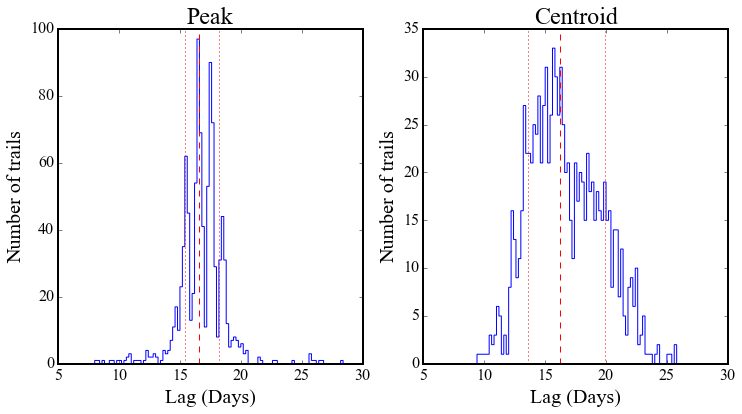

In [43]:
start = timeit.default_timer()

ntrails = 1000
lag_peak_all=[]
lag_cen_all=[]
for n in range(ntrails):
    y1_new = y1 + np.random.randn(len(y1))*e1
    y2_new = y2 + np.random.randn(len(y2))*e2
    
    lag,r,npt=iccf(t1,y1_new,t2,y2_new,tau_min,tau_max,step,imode=0)
    lag_peak,lag_cen=lag_center(lag,r)
    lag_peak_all.append(lag_peak)
    lag_cen_all.append(lag_cen)
end = timeit.default_timer()
print 'Fitting finished in : '+str(np.round(end-start))+'s'

#
#-------plot-------
lag_peak_low=np.percentile(lag_peak_all, 50)-np.percentile(lag_peak_all, 16)
lag_peak_high=np.percentile(lag_peak_all, 84)-np.percentile(lag_peak_all, 50)
lag_peak=np.percentile(lag_peak_all, 50)
lag_cen_low=np.percentile(lag_cen_all, 50)-np.percentile(lag_cen_all, 16)
lag_cen_high=np.percentile(lag_cen_all, 84)-np.percentile(lag_cen_all, 50)
lag_cen=np.percentile(lag_cen_all, 50)

plt.figure(figsize=(12,6))
plt.subplot(121)
a=plt.hist(lag_peak_all,np.arange(5,30,0.2),histtype='step')
ymin,ymax=plt.ylim()
plt.plot([lag_peak-lag_peak_low,lag_peak-lag_peak_low],[ymin,ymax],'r:',lw=1)
plt.plot([lag_peak,lag_peak],[ymin,ymax],'r--',lw=1)
plt.plot([lag_peak+lag_peak_high,lag_peak+lag_peak_high],[ymin,ymax],'r:',lw=1)
ymin,ymax=plt.ylim()

plt.title('Peak')
plt.xlabel('Lag (Days)')
plt.ylabel('Number of trails')

plt.subplot(122)
#print lag_cen_all
a=plt.hist(lag_cen_all,np.arange(5,30,0.2),histtype='step')
ymin,ymax=plt.ylim()
plt.plot([lag_cen-lag_cen_low,lag_cen-lag_cen_low],[ymin,ymax],'r:',lw=1)
plt.plot([lag_cen,lag_cen],[ymin,ymax],'r--',lw=1)
plt.plot([lag_cen+lag_cen_high,lag_cen+lag_cen_high],[ymin,ymax],'r:',lw=1)
plt.title('Centroid')

plt.xlabel('Lag (Days)')
plt.ylabel('Number of trails')

### 7. Fit the continuum and emission line light curves with carma model. Here p =1 and q =0.

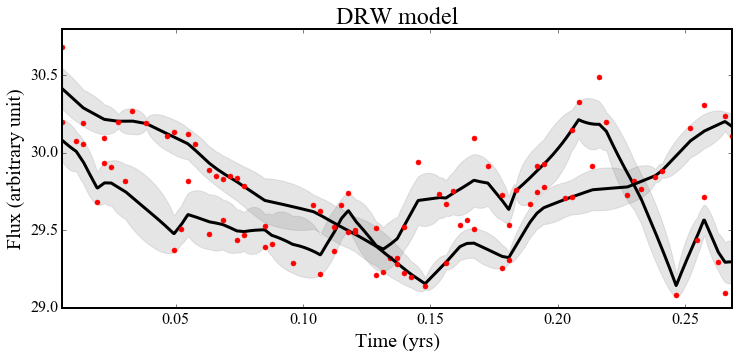

In [44]:
plt.figure(figsize=(12,5))
carma_p,carma_q=1,0
plt.subplot(111)
model = cm.CarmaModel(t1, y1, e1, p=carma_p, q=carma_q)
sample = model.run_mcmc(5000)
sample.assess_fit(nplot=1000)


model = cm.CarmaModel(t2, y2, e2, p=carma_p, q=carma_q)
sample = model.run_mcmc(5000)
sample.assess_fit(nplot=1000)
plt.title('DRW model')

plt.xlabel('Time (yrs)')
plt.ylabel('Flux (arbitrary unit)')

### 8. Incorporate carma model into ICCF to interpolate the light curves. 

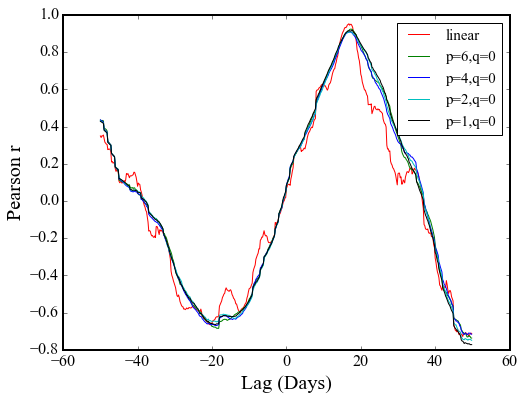

In [45]:
t1=t_cont
y1=f_cont
e1=e_cont
t2=t_line
y2=f_line
e2=e_line
tau_min=-50
tau_max=50
step=0.2

carma_p,carma_q=1,0
mcmc_nsamples=5000
interp='carma'
interp='linear'

def iccf_carma(t1,y1,e1,t2,y2,e2,tau_min,tau_max,step=0.2, interp='linear', mcmc_nsamples=2000, carma_p=1,carma_q=0,imode=0):

    lag_12=[]
    r_12=[]
    npt_12=[]
    lag_21=[]
    r_21=[]
    npt_21=[]
    sig_12=[]
    sig_21=[]


    # interplate y2
    if imode!=2:
        if interp=='carma':
            #interplate y2 with carma first.
            model = cm.CarmaModel(t2, y2, e2, p=carma_p, q=carma_q)
            sample = model.run_mcmc(mcmc_nsamples)
            time=np.linspace(t2.min(),t2.max(),int((t2.max()-t2.min())/step))
            model_mean, model_var = sample.predict(time, bestfit='map')
            t2,y2=time,model_mean
        
        tau=tau_min
        while tau < tau_max:
            lag_12.append(tau)
            t2_new=t2+tau
            ind_t2=np.where( (t2_new >= t1.min()) & (t2_new <= t1.max()),True,False)
            ind_t1=np.where( (t1<=t2_new.max()) & (t1>=t2_new.min()),True,False)
            npt_12.append(min(np.sum(ind_t2),np.sum(ind_t1)))
            if npt_12 > 0:
                y2_new=np.interp(t1[ind_t1],t2_new[ind_t2],y2[ind_t2])
                r,p=sst.spearmanr(y1[ind_t1],y2_new)
                r_12.append(r)
                sig_12.append(p)
                tau=tau+step
            else:
                raise Exception("No overlaping data in two light curves!")

        lag_12=np.array(lag_12)   
        r_12=np.array(r_12)
        r_12=r_12[::-1] 
        sig_12=np.array(sig_12)
        npt_12=np.array(npt_12)
        npt_12=npt_12[::-1]

    exit
    # interplate y1
    if imode !=1:
        if interp=='carma':
            #interplate y1 with carma first.
            model = cm.CarmaModel(t1, y1, e1, p=carma_p, q=carma_q)
            sample = model.run_mcmc(mcmc_nsamples)
            time=np.linspace(t1.min(),t1.max(),int((t1.max()-t1.min())/step))
            model_mean, model_var = sample.predict(time, bestfit='map')
            t1,y1=time,model_mean
        
        tau=tau_min
        while tau < tau_max:
            lag_21.append(tau)
            t1_new=t1+tau
            ind_t1=np.where( (t1_new >= t2.min()) & (t1_new <= t2.max()),True,False)
            ind_t2=np.where( (t2<=t1_new.max()) & (t2>=t1_new.min()),True,False)
            npt_21.append(min(np.sum(ind_t2),np.sum(ind_t1)))
            if npt_21 >0:
                y1_new=np.interp(t2[ind_t2],t1_new[ind_t1],y1[ind_t1])
                r,p=sst.spearmanr(y2[ind_t2],y1_new)
                r_21.append(r)
                sig_21.append(r)
                tau=tau+step
            else:
                raise Exception("No overlaping data in two light curves!") 

        lag_21=np.array(lag_21)
        r_21=np.array(r_21)
        sig_21=np.array(sig_21)
        npt_21=np.array(npt_21)


    if imode==0:
        lag=(lag_12+lag_21)*0.5
        r=(r_12+r_21)*0.5
        sig=(sig_12+sig_21)*0.5
        npt=(npt_12+npt_21)*0.5
    elif imode==1:
        lag=lag_12
        r=r_12
        sig=sig_12
        npt=npt_12
    elif imode==2:
        lag=lag_21
        r=r_21
        sig=sig_21
        npt=npt_21    
    else:
        raise Exception("Please select imode = 0, 1 or 2!") 
    return lag, r, npt

plt.figure(figsize=(8,6))
lag, r, npt = iccf_carma(t1,y1,e1,t2,y2,e2,tau_min,tau_max,step=0.2,interp='linear',imode=0)
plt.plot(lag,r,'r',lw=1,label='linear')

lag, r, npt = iccf_carma(t1,y1,e1,t2,y2,e2,tau_min,tau_max,step=0.2,interp='carma',carma_p=6,carma_q=0,imode=0)
plt.plot(lag,r,'g',lw=1,label='p=6,q=0')

lag, r, npt = iccf_carma(t1,y1,e1,t2,y2,e2,tau_min,tau_max,step=0.2,interp='carma',carma_p=4,carma_q=0,imode=0)
plt.plot(lag,r,'b',lw=1,label='p=4,q=0')

lag, r, npt = iccf_carma(t1,y1,e1,t2,y2,e2,tau_min,tau_max,step=0.2,interp='carma',carma_p=2,carma_q=0,imode=0)
plt.plot(lag,r,'c',lw=1,label='p=2,q=0')


lag, r, npt = iccf_carma(t1,y1,e1,t2,y2,e2,tau_min,tau_max,step=0.2,interp='carma',carma_p=1,carma_q=0,imode=0)
plt.plot(lag,r,'k',lw=1,label='p=1,q=0')

plt.legend(fontsize=15)
plt.xlabel('Lag (Days)')
plt.ylabel('Pearson r')


### 9. Interpolation with different methods.

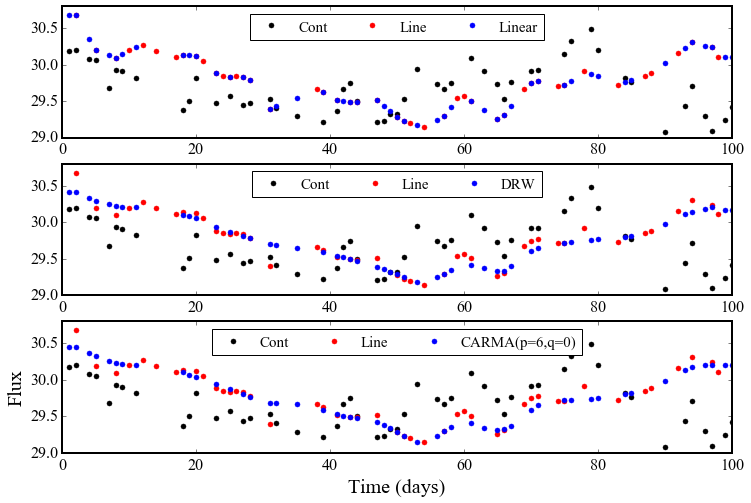

In [46]:
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.plot(t1,y1,'k.',label='Cont')
plt.plot(t2,y2,'r.',label='Line')
y2_l=np.interp(t1,t2,y2)
plt.plot(t1,y2_l,'b.',label='Linear')
plt.legend(fontsize=15,numpoints=1,ncol=3,loc='best')


plt.subplot(312)
plt.plot(t1,y1,'k.',label='Cont')
plt.plot(t2,y2,'r.',label='Line')

model = cm.CarmaModel(t2, y2, e2, p=1, q=0)
sample = model.run_mcmc(mcmc_nsamples)
time=np.linspace(t2.min(),t2.max(),int((t2.max()-t2.min())/step))
model_mean, model_var = sample.predict(time, bestfit='map')
t2_tem,y2_tem=time,model_mean
y2_1=np.interp(t1,t2_tem,y2_tem)
plt.plot(t1,y2_1,'b.',label='DRW')
plt.legend(fontsize=15,numpoints=1,ncol=3,loc='best')


plt.subplot(313)
plt.plot(t1,y1,'k.',label='Cont')
plt.plot(t2,y2,'r.',label='Line')

model = cm.CarmaModel(t2, y2, e2, p=6, q=0)
sample = model.run_mcmc(mcmc_nsamples)
time=np.linspace(t2.min(),t2.max(),int((t2.max()-t2.min())/step))
model_mean, model_var = sample.predict(time, bestfit='map')
t2_tem,y2_tem=time,model_mean
y2_1=np.interp(t1,t2_tem,y2_tem)
plt.plot(t1,y2_1,'b.',label='CARMA(p=6,q=0)')
plt.legend(fontsize=15,numpoints=1,ncol=3,loc='best')

plt.xlabel('Time (days)')
plt.ylabel('Flux')


### 10. Simulate new light curves with the same variability characterastics as the original light curve. 

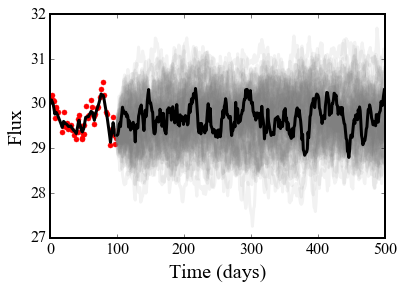

In [47]:
model = cm.CarmaModel(t1, y1, e1, p=1, q=0)
sample = model.run_mcmc(5000)


time0=np.arange(0,100,1)
model_mean, model_var = sample.predict(time0)
plt.plot(t1,y1,'r.')
plt.plot(time0,model_mean,'k')

time1=np.arange(100,500,1)

for i in range(100):
    ysim = sample.simulate(time1, bestfit='random')
    plt.plot(time1,ysim,'grey',alpha=0.1)
ysim = sample.simulate(time1, bestfit='map')
plt.plot(time1,ysim,'k',alpha=1)
    
plt.xlabel('Time (days)')
plt.ylabel('Flux')

### 11. Evaluate the lag significance with the ICCF between real and simulated light curves. 

Fitting finished in : 1049.0s


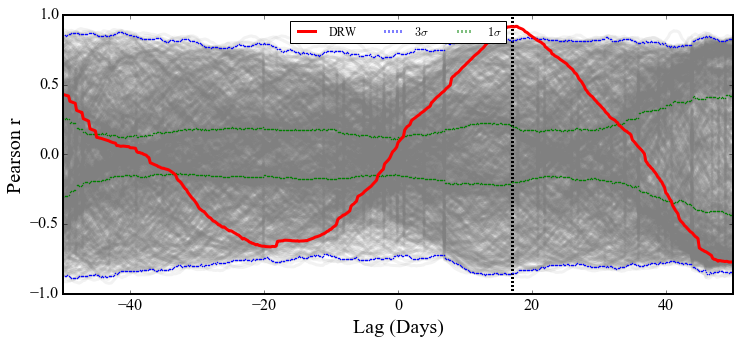

In [75]:
start = timeit.default_timer()
ntrails_sig=1000

model = cm.CarmaModel(t2, y2, e2, p=carma_p, q=carma_q)
sample = model.run_mcmc(mcmc_nsamples)
r_all=[]
lag_sim_all=[]
r_sim_all=[]
plt.figure(figsize=(12,5))
plt.subplot(111)

for i in range(ntrails_sig):
    
    tsim=np.arange(3*t1.max(),3*t1.max()+t1.max()-t1.min(),(t1.max()-t1.min())/t1.shape[0])
    ysim = sample.simulate(tsim, bestfit='random')
    tsim=tsim-tsim.min()
    
    esim=np.random.normal(0.2, 0.1, len(tsim))
    
    lagsim, rsim, nptsim = iccf_carma(t1,y1,e1,tsim,ysim,esim,tau_min,tau_max,interp='carma',imode=0)
    lag_sim_all.append(lagsim)
    r_sim_all.append(rsim)
    plt.plot(lagsim,rsim,'gray',alpha=0.1)
    idx = np.abs(lagsim - lag[np.argmax(r)]).argmin()
    
    r_all.append(rsim[idx])
    plt.plot([17,17],[-1,1],'k:')
    plt.xlim(tau_min,tau_max)
    plt.xlabel('Lag (Days)')
    plt.ylabel('Pearson r')

lag_sim_all = np.array(lag_sim_all)
r_sim_all=np.array(r_sim_all)

for i in range(r_sim_all.shape[1]):
    plt.plot(lag_sim_all[0,i],np.percentile(r_sim_all[:,i], 99.7),'b.',ms=2)
    plt.plot(lag_sim_all[0,i],np.percentile(r_sim_all[:,i], 100-34.1),'g.',ms=2)
    plt.plot(lag_sim_all[0,i],np.percentile(r_sim_all[:,i], 34.1),'g.',ms=2)
    plt.plot(lag_sim_all[0,i],np.percentile(r_sim_all[:,i], 100-99.7),'b.',ms=2)
plt.plot(lag,r,'r',label='DRW')
plt.plot([],[],'b:',label=r'$3\sigma$')
plt.plot([],[],'g:',label=r'$1\sigma$')
end = timeit.default_timer()
print 'Fitting finished in : '+str(np.round(end-start))+'s'
plt.legend(loc='best',ncol=3)

### 12. Find the best carma model for any input light curve. 

p, q, AICc:
1 0 -29.1892614576
2 0 -27.9178337683
2 1 -25.4645496458
3 0 -27.806358282
3 1 -25.4508134305
3 2 -25.9078812796
4 0 -31.3357413028
4 1 -29.4044237118
4 2 -26.6010410515
4 3 -25.4416744112
5 0 -29.0420645506
5 1 -27.8554950133
5 2 -24.9186176918
5 3 -21.8384779177
5 4 -19.631633249
6 0 -27.2305443058
6 1 -28.295610504
6 2 -25.2154745241
6 3 -24.0324173992
6 4 -20.6324175415
6 5 -17.0850452804
7 0 -24.465782959
7 1 -25.1600520314
7 2 -21.9259069504
7 3 -20.611168265
7 4 -17.0322216747
7 5 -13.5111223936
7 6 -9.52913617644
Model with best AICc has p = 4  and q =  0


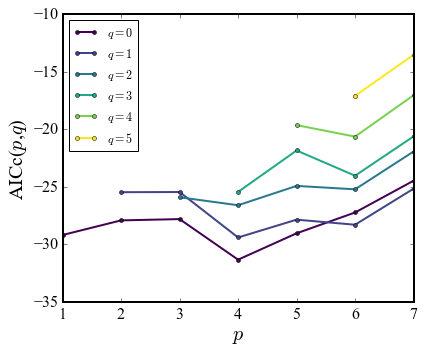

In [50]:
model = cm.CarmaModel(t1,y1,e1)
sample = model.run_mcmc(mcmc_nsamples)
#log_omega = sample.get_samples('p')
best_MLE, pqlist, AICc = model.choose_order(7,njobs=-1,ntrials=100)
from matplotlib import cm as cmap
colors = [cmap.viridis(x) for x in np.linspace(0, 1, 6)]
p,q = zip(*pqlist)
q=np.array(q)
p=np.array(p)
AICc=np.array(AICc)
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.plot(p[q==0],AICc[q==0],color=colors[0],label=r'$q=0$', lw=2, marker='o', ms=4)
ax.plot(p[q==1],AICc[q==1],color=colors[1],label=r'$q=1$', lw=2, marker='o', ms=4)
ax.plot(p[q==2],AICc[q==2],color=colors[2],label=r'$q=2$', lw=2, marker='o', ms=4)
ax.plot(p[q==3],AICc[q==3],color=colors[3],label=r'$q=3$', lw=2, marker='o', ms=4)
ax.plot(p[q==4],AICc[q==4],color=colors[4],label=r'$q=4$', lw=2, marker='o', ms=4)
ax.plot(p[q==5],AICc[q==5],color=colors[5],label=r'$q=5$', lw=2, marker='o', ms=4)
#ax.plot(p[q==6],AICc[q==6],color='k',label=r'$q=6$', lw=2, marker='o')
ax.legend(loc='best')
ax.set_ylabel(r'AICc($p$,$q$)')
ax.set_xlabel(r'$p$')
fig.tight_layout()
